In [17]:
load("grant_Data.Rdata")

[1] "English_United States.1252"

 chr [1:1073] "NumCI" "NumDR" "NumECI" "NumEA" "NumHV" "NumPS" "NumSCI" ...
 chr [1:252] "NumCI" "NumDR" "NumECI" "NumPS" "NumSCI" "NumSR" "NumUNK" ...


`there are 1073 predictors in fullSet, However the book show only 1070 predictors @page 311`

In [30]:
reducedCovMat <- cov(training[,reducedSet])
library(subselect)
trimmingResults <- trim.matrix(reducedCovMat)
names(trimmingResults)
trimmingResults$names.discarded

[1] "trimmedmat"        "numbers.discarded" "names.discarded"  
[4] "size"

In [34]:
#apply to full set
fullCovMat <- cov(training[,fullSet])
fullSetResults <- trim.matrix(fullCovMat)
fullSetResults$names.discarded

[1] "NumDR"       "PS.1975"     "CI.Dept1798" "PS.Dept3028" "PS.Faculty1"
[6] "BTotal"      "numPeople"   "Apr"         "Sun"

In [2]:
levels(training$Class)

[1] "successful"   "unsuccessful"

In [19]:
library(caret)
fit_glt <- glm(Class~Day,
              data=training[pre2008,],
              family=binomial)
fit_glt


Call:  glm(formula = Class ~ Day, family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day  
  -0.919335     0.004238  

Degrees of Freedom: 6632 Total (i.e. Null);  6631 Residual
Null Deviance:	    9191 
Residual Deviance: 8919 	AIC: 8923

In [20]:
successProb <- 1- predict(
                          fit_glt,
                          newdata = data.frame(Day=c(10,150,300,350)),
                         type="response")

successProb

1         2         3         4 
0.7061907 0.5704337 0.4128749 0.3626229

In [21]:
fit_daySquared <- glm(
                      Class~Day + I(Day^2),
                     data=training[pre2008,],
                     family=binomial)
fit_daySquared


Call:  glm(formula = Class ~ Day + I(Day^2), family = binomial, data = training[pre2008, 
    ])

Coefficients:
(Intercept)          Day     I(Day^2)  
  -1.881341     0.018622    -0.000038  

Degrees of Freedom: 6632 Total (i.e. Null);  6630 Residual
Null Deviance:	    9191 
Residual Deviance: 8721 	AIC: 8727

In [22]:
library(rms)
fit_rcs <- lrm(Class~rcs(Day),data=training[pre2008,])
fit_rcs

Logistic Regression Model
 
 lrm(formula = Class ~ rcs(Day), data = training[pre2008, ])
 
                       Model Likelihood     Discrimination    Rank Discrim.    
                          Ratio Test           Indexes           Indexes       
 Obs          6633    LR chi2     461.53    R2       0.090    C       0.614    
  successful  3233    d.f.             4    g        0.538    Dxy     0.228    
  unsuccessful3400    Pr(> chi2) <0.0001    gr       1.713    gamma   0.237    
 max |deriv| 2e-06                          gp       0.122    tau-a   0.114    
                                            Brier    0.234                     
 
           Coef    S.E.   Wald Z Pr(>|Z|)
 Intercept -1.6833 0.1110 -15.16 <0.0001 
 Day        0.0124 0.0013   9.24 <0.0001 
 Day'      -0.0072 0.0023  -3.17 0.0015  
 Day''      0.0193 0.0367   0.52 0.6001  
 Day'''    -0.0888 0.1026  -0.87 0.3866  
 

In [23]:
max(training[pre2008,'Day'])

[1] 357

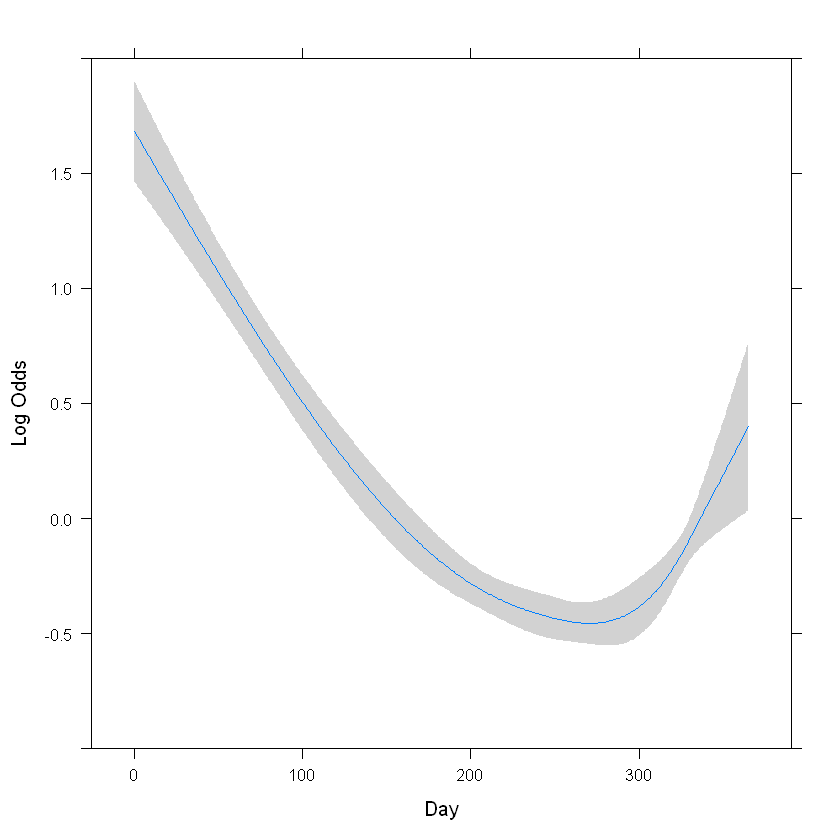

In [24]:
dayProfile <- Predict(fit_rcs,Day=0:365,fun=function(x)-x)
plot(dayProfile,ylab="Log Odds")

In [4]:
training$Day2 <- training$Day^2
fullSet <- c(fullSet,"Day2")
reducedSet <- c(reducedSet,"Day2")

In [6]:
library(caret)
set.seed(476)
ctrl <- trainControl(method = "LGOCV",
                     summaryFunction = twoClassSummary,
                     classProbs = TRUE,
                     index = list(TrainSet = pre2008),
                     savePredictions = TRUE)

fit_lrFull <- train(
                    training[,fullSet],y=training$Class,
                    method="glm",metric="ROC",trControl=ctrl)
fit_lrFull     

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

Generalized Linear Model 

8190 samples
1074 predictors
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results:

  ROC        Sens       Spec     
  0.7820882  0.7701754  0.7619048


&#x1F640;
- [prediction from a rank-deficient fit may be misleading](http://bbs.pinggu.org/thread-3033898-1-1.html)
- [glm.fit: fitted probabilities numerically 0 or 1 occurred](https://blog.csdn.net/m0_37119401/article/details/71007117?locationNum=7&fps=1)

In [11]:
set.seed(476)
fit_lrReduced <- train(
                      training[,reducedSet],
                      y=training$Class,
                      method = "glm",
                      metric="ROC",
                      trControl=ctrl)
fit_lrReduced

Generalized Linear Model 

8190 samples
 253 predictor
   2 classes: 'successful', 'unsuccessful' 

No pre-processing
Resampling: Repeated Train/Test Splits Estimated (1 reps, 75%) 
Summary of sample sizes: 6633 
Resampling results:

  ROC        Sens       Spec     
  0.8715406  0.8035088  0.8216819


In [13]:
head(fit_lrReduced$pred)

pred,obs,successful,unsuccessful,rowIndex,parameter,Resample
successful,successful,0.9987762,0.001223821,6634,none,TrainSet
successful,successful,0.8515076,0.148492399,6635,none,TrainSet
successful,successful,0.9201932,0.079806850,6636,none,TrainSet
successful,successful,0.9669428,0.033057191,6637,none,TrainSet
successful,unsuccessful,0.6072577,0.392742264,6638,none,TrainSet
successful,successful,0.9892840,0.010715961,6639,none,TrainSet


In [15]:
confusionMatrix(data=fit_lrReduced$pred$pred,reference = fit_lrReduced$pred$obs)

Confusion Matrix and Statistics

              Reference
Prediction     successful unsuccessful
  successful          458          176
  unsuccessful        112          811
                                         
               Accuracy : 0.815          
                 95% CI : (0.7948, 0.834)
    No Information Rate : 0.6339         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.6107         
 Mcnemar's Test P-Value : 0.0002054      
                                         
            Sensitivity : 0.8035         
            Specificity : 0.8217         
         Pos Pred Value : 0.7224         
         Neg Pred Value : 0.8787         
             Prevalence : 0.3661         
         Detection Rate : 0.2942         
   Detection Prevalence : 0.4072         
      Balanced Accuracy : 0.8126         
                                         
       'Positive' Class : successful     
                            

Area under the curve: 0.8715

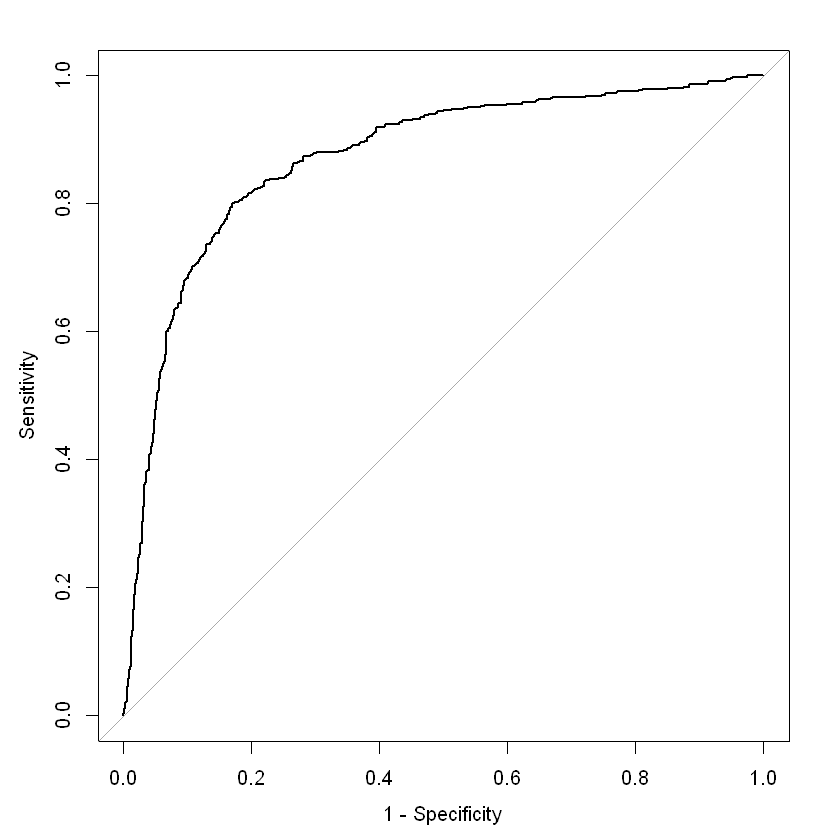

In [18]:
library(pROC)
roc_reduced <- roc(
                   response = fit_lrReduced$pred$obs,
                   predictor = fit_lrReduced$pred$successful,
                  levels=rev(levels(fit_lrReduced$pred$obs)))

plot(roc_reduced,legacy.axes=T)
auc(roc_reduced)